# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/Store-Sales-Forecasting/oil.csv
/kaggle/input/Store-Sales-Forecasting/sample_submission.csv
/kaggle/input/Store-Sales-Forecasting/holidays_events.csv
/kaggle/input/Store-Sales-Forecasting/stores.csv
/kaggle/input/Store-Sales-Forecasting/train.csv
/kaggle/input/Store-Sales-Forecasting/test.csv
/kaggle/input/Store-Sales-Forecasting/transactions.csv


In [2]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb

warnings.filterwarnings("ignore")

# Loading the Data

In [3]:
DATA_DIR = "/kaggle/input/Store-Sales-Forecasting"
VAL_DAYS = 16
SEED = 42

train = pd.read_csv(f"{DATA_DIR}/train.csv", parse_dates=['date'])
test = pd.read_csv(f"{DATA_DIR}/test.csv", parse_dates=['date'])

stores = pd.read_csv(f"{DATA_DIR}/stores.csv")
oil = pd.read_csv(f"{DATA_DIR}/oil.csv", parse_dates=['date'])

holidays = pd.read_csv(f"{DATA_DIR}/holidays_events.csv", parse_dates=['date'])
transactions = pd.read_csv(f"{DATA_DIR}/transactions.csv", parse_dates=['date'])
sample_sub = pd.read_csv(f"{DATA_DIR}/sample_submission.csv")

# Preprocessing

In [4]:
# Fill missing oil prices

print("BEFORE")
print(oil.head())

print("AFTER")
#Forward and Backward Fill
oil['dcoilwtico'] = oil['dcoilwtico'].ffill().bfill()
print(oil.head())

BEFORE
        date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20
AFTER
        date  dcoilwtico
0 2013-01-01       93.14
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20


In [5]:
# Holidays simplified

holidays['is_holiday'] = holidays['type'].isin(['Holiday','Additional']).astype(int)
holidays = holidays.fillna(0)
holidays = holidays[['date', 'is_holiday']]

transactions = transactions.fillna(0)
print(holidays.head)

<bound method NDFrame.head of           date  is_holiday
0   2012-03-02           1
1   2012-04-01           1
2   2012-04-12           1
3   2012-04-14           1
4   2012-04-21           1
..         ...         ...
345 2017-12-22           1
346 2017-12-23           1
347 2017-12-24           1
348 2017-12-25           1
349 2017-12-26           1

[350 rows x 2 columns]>


In [6]:
print("TRAIN")
print(train.head())
print("\nSTORES")
print(stores.head())
print("\nOIL")
print(oil.head())

# Merge Datasets

for name, df in [('train', train), ('test', test)]:
    df = df.merge(stores, on = "store_nbr", how = "left")
    df = df.merge(oil, on = "date", how = "left")
    df = df.merge(holidays, on = "date", how = "left")
    df = df.merge(transactions, on = ["date", "store_nbr"], how = "left")
    
    if name == 'train':
        train = df
    else:
        test = df

print("MERGED\n")
print(train.head())

TRAIN
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

STORES
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

OIL
        date  dcoilwtico
0 2013-01-01       93.14
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20
MERGED

   id       date  s

In [7]:
# Sort Dates

for name, df in [('train', train), ('test', test)]:
    df['day'] = df['date'].dt.day
    df['dow'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['is_weekend'] = df['dow'].isin([5,6]).astype(int)

    if name == 'train':
        train = df
    else:
        test = df

train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,is_holiday,transactions,day,dow,month,year,is_weekend
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,1.0,NaN,1,1,1,2013,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,1.0,NaN,1,1,1,2013,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,1.0,NaN,1,1,1,2013,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,1.0,NaN,1,1,1,2013,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,1.0,NaN,1,1,1,2013,0


# Feature Engineering

In [8]:
# Label Encoders for categorical columns

for col in ['family', 'city', 'state', 'type']:
    le = LabelEncoder()
    le.fit(pd.concat([train[col], test[col]], axis = 0).astype(str))
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,is_holiday,transactions,day,dow,month,year,is_weekend
0,0,2013-01-01,1,0,0.0,0,18,12,3,13,93.14,1.0,NaN,1,1,1,2013,0
1,1,2013-01-01,1,1,0.0,0,18,12,3,13,93.14,1.0,NaN,1,1,1,2013,0
2,2,2013-01-01,1,2,0.0,0,18,12,3,13,93.14,1.0,NaN,1,1,1,2013,0
3,3,2013-01-01,1,3,0.0,0,18,12,3,13,93.14,1.0,NaN,1,1,1,2013,0
4,4,2013-01-01,1,4,0.0,0,18,12,3,13,93.14,1.0,NaN,1,1,1,2013,0


In [10]:
# Lag Features

train['id'] = train['store_nbr'].astype(str) + '_' + train['family'].astype(str)
test['id'] = test['store_nbr'].astype(str) + '_' + test['family'].astype(str)

train = train.sort_values(['id','date'])
test = test.sort_values(['id','date'])

full_df = pd.concat([train[['id','date','sales']], test[['id','date']]], axis = 0, sort = False)
full_df = full_df.sort_values(['id','date'])

for lag in [7,14,28]:
    full_df[f'lag_{lag}'] = full_df.groupby('id')['sales'].shift(lag)
    full_df[f'roll_mean_{lag}'] = (full_df.groupby('id')['sales'].shift(7).rolling(lag).mean().reset_index(0,drop=True))

train = train.merge(full_df[['id', 'date', 'lag_7', 'lag_14', 'lag_28',
                             'roll_mean_7', 'roll_mean_14', 'roll_mean_28']],
                    on=['id', 'date'], how='left')
test = test.merge(full_df[['id', 'date', 'lag_7', 'lag_14', 'lag_28',
                           'roll_mean_7', 'roll_mean_14', 'roll_mean_28']],
                  on=['id', 'date'], how='left')

train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,dow,month,year,is_weekend,lag_7,lag_14,lag_28,roll_mean_7,roll_mean_14,roll_mean_28
0,10_0,2013-01-01,10,0,0.0,0,18,12,2,15,...,1,1,2013,0,NaN,NaN,NaN,1.428571,1.500000,NaN
1,10_0,2013-01-02,10,0,3.0,0,18,12,2,15,...,2,1,2013,0,NaN,NaN,NaN,0.000000,0.000000,0.000000
2,10_0,2013-01-03,10,0,2.0,0,18,12,2,15,...,3,1,2013,0,NaN,NaN,NaN,39.857143,35.285714,33.000000
3,10_0,2013-01-04,10,0,2.0,0,18,12,2,15,...,4,1,2013,0,NaN,NaN,NaN,19.857143,23.056786,26.531000
4,10_0,2013-01-05,10,0,0.0,0,18,12,2,15,...,5,1,2013,1,NaN,NaN,NaN,2280.571429,2298.857143,2312.035714


In [11]:
train = train.dropna(subset=['lag_7', 'lag_14', 'lag_28']).reset_index(drop=True)

# Train Test Split

In [13]:
max_date = train['date'].max()
val_start = max_date - pd.Timedelta(days=VAL_DAYS - 1)
train_mask = train['date'] < val_start
val_mask = train['date'] >= val_start

train_mask

0           True
1           True
2           True
3           True
4           True
           ...  
3136315    False
3136316    False
3136317    False
3136318    False
3136319    False
Name: date, Length: 3136320, dtype: bool

In [16]:
features = ['onpromotion', 'transactions', 'dcoilwtico', 'is_holiday',
    'day', 'dow', 'month', 'year', 'is_weekend',
    'family', 'city', 'state', 'type',
    'lag_7', 'lag_14', 'lag_28',
    'roll_mean_7', 'roll_mean_14', 'roll_mean_28']

X_train, y_train = train.loc[train_mask, features], np.log1p(train.loc[train_mask, 'sales'])
X_val, y_val = train.loc[val_mask, features], np.log1p(train.loc[val_mask, 'sales'])

# Model Initialization

In [18]:
model = lgb.LGBMRegressor(
    objective = 'regression',
    learning_rate = 0.05,
    num_leaves = 128,
    feature_fraction = 0.8,
    bagging_fraction = 0.8,
    bagging_freq = 5,
    random_state = SEED,
    n_estimators = 5000,
    n_jobs = -1
)

model.fit(
    X_train, y_train,
    eval_set = [(X_val, y_val)],
    eval_metric = "rmse",
    callbacks = [lgb.early_stopping(100), lgb.log_evaluation(200)]
)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2378
[LightGBM] [Info] Number of data points in

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
              learning_rate=0.05, n_estimators=5000, n_jobs=-1, num_leaves=128,
              objective='regression', random_state=42)

In [19]:
val_pred = np.expm1(model.predict(X_val))
y_true = np.expm1(y_val)
rmsle = np.sqrt(np.mean(np.square(np.log1p(val_pred) - np.log1p(y_true))))
print(f"✅ Validation RMSLE: {rmsle:.5f}")

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
✅ Validation RMSLE: 0.39308


# TEST PREDICTION

In [20]:
X_test = test[features].fillna(0)
test_pred = np.expm1(model.predict(X_test))
test_pred = np.clip(test_pred, 0, None)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


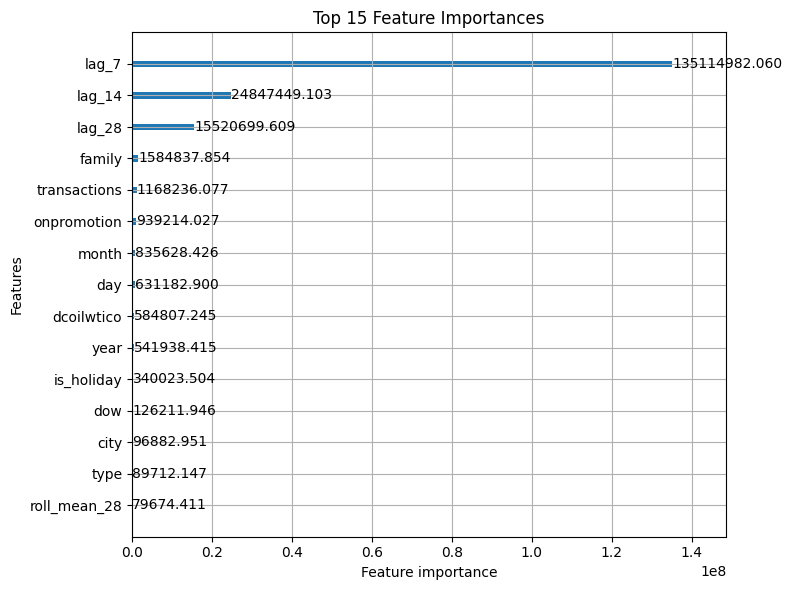

In [21]:
lgb.plot_importance(model, importance_type='gain', max_num_features=15, figsize=(8, 6))
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()

In [ ]:
# SUBMISSION
# ---------------------------------------------------------------
submission = sample_sub.copy()
submission['sales'] = test_pred
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved successfully!")